# The Habitual DDPG Network

Habitual network

Assuming generative model is perfect, then action selected would always be the action that maximises chance of observing prior preferences. Hence habitual network can be trained to output maximally rewarding actions, as these actions are the free energy minimising actions.

Also has a nice interpretation as long as the generative models keep training. Eventually the generative model is less sure about old things. Why people eventually revisit old states they were previously certain about.

As far as an agent knows, if observations are confirming perfectly to expectations then it has a perfect world model. So why would it change it? It’s only when an uncertain observation comes in that the agent needs to reconsider whether or not it has the best model of the world.


I think this network should be performing policy gradient method but instead of minimising the discounted reward sequence it should minimise the discounted external EFE/FEEF component sequence. That way in the end the end the fast and slow thinking methods should be converging as the world model continues to improve


What is this network trying to learn?
- This network is trying to learn the state action mapping that maximises the probability of being in the preferred states
- It is also trying to learn to output actions that minimise the extrinsic part of the EFE/FEEF


What does this network take as input?
- Current state
- Maybe sequence of previous states and actions

What should this network output?
- The action that leads to the next state that maximally achieves the prior preferences

How should this network learn?
- It should learn by outputting


Okay so new idea! DDPG seems pretty good so far. How about we have the Q function take latent states as input and use the VAEs good latent features as input. Then we'll have
- Q(o, a)
- p(s|o) and p(o|s)
- p(s'|s, a)
- V(o) or U(o)



In [2]:
from util import random_observation_sequence, transform_observations, test_policy
import gym
from train_agent import train_single_model_free_agent

from ddpg import *

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [3]:
env = gym.make("MountainCarContinuous-v0")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  2
Size of Action Space ->  1
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [4]:
actor_model = get_actor(2, 1, [16, 16])
critic_model = get_critic(2, 1, [16], [16], [20])

target_actor = get_actor(2, 1, [16, 16])
target_critic = get_critic(2, 1, [16], [16], [20])

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0001
actor_lr = 0.00005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 140
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

# buffer = Buffer(50000, 64, 0.99, 2, 1, critic_optimizer, actor_optimizer)

ddpg = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau, observation_dim=2,
                 action_dim=1, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [5]:
t_max = 1000
num_episodes = 150

min_reward_cutoff = -1000
min_reward_set = -0.5

reward_increase = 0

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_max = np.array([0.6, 0.07])
# observation_min = np.array([-1.2, -0.07])

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []

    total_reward = 0

    o, a, r = random_observation_sequence(env, t_max, epsilon=0.2)
    o = transform_observations(o, observation_max, observation_min, [0, 0])
    # o = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # print(o)
    # print(o)
    for i in range(len(a)):

        prev_state = o[i]
        state = o[i+1]
        action = a[i]
        reward = r[i] + reward_increase


        total_reward += reward

        # ddpg.buffer.record((prev_state, action, reward, state))
        # # episodic_reward += reward
        #
        # ddpg.buffer.learn()

        ddpg.record((prev_state, action, reward, state))
        # episodic_reward += reward

        ddpg.train([], [], [], [])

    print(total_reward)

    acts = ddpg.actor_model((np.random.random(size=(10, 2))*2 - 1))
    print(np.max(acts), np.min(acts))


2022-10-15 18:41:02.876767: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


88.67307074412336
-0.02411329 -0.055731617
-31.357191707353763
-0.024899693 -0.03941303
90.28567234790687
-0.018826136 -0.03544874
-33.109628440133875
0.079351604 0.028848806
-34.57496934587841
0.09155329 0.042207506
71.02306346644536
0.09158766 0.051958494
75.63411365741706
0.08312993 0.05716828
87.41808940046747
0.104938954 0.060644038
86.48208797019805
0.12569404 0.07276759
-29.093965242307306
0.20851487 0.058963045
68.7720415305783
0.18429331 0.0824684
82.54540745368445
0.12886533 0.10073798
69.41191550189042
0.11564513 0.096917994
75.57270291953608
0.13140851 0.07464755
-35.15399459893552
0.12967123 0.09446145
87.72688816814056
0.15074688 0.0886904
85.37244676735845
0.19568372 0.09949792
84.83112937767676
0.23917755 0.1319445
-36.91989150616649
0.2550646 0.11500997
87.82145562860839
0.28823477 0.1125123
-34.742314208162604
0.32859793 0.2281347
85.51181926379594
0.32682654 0.0728615
-35.31545732972517
0.35536852 -0.017031742
-36.37435354359562
0.34429234 0.10098719
85.1016976268887

In [6]:
ddpg.critic_model([(np.random.random(size=(10, 2))*2 - 1), (np.random.random(size=(10, 1))*2 - 1)])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 98.642235],
       [220.37552 ],
       [101.128685],
       [ 77.02902 ],
       [161.37643 ],
       [202.77823 ],
       [383.27588 ],
       [327.13275 ],
       [459.1449  ],
       [203.4675  ]], dtype=float32)>

In [7]:
ddpg.actor_model((np.random.random(size=(10, 2))*2 - 1))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.99999976],
       [0.99999976],
       [0.99999976],
       [0.99999976],
       [0.99999976],
       [0.99999976],
       [0.99999976],
       [0.99999976],
       [1.        ],
       [1.        ]], dtype=float32)>

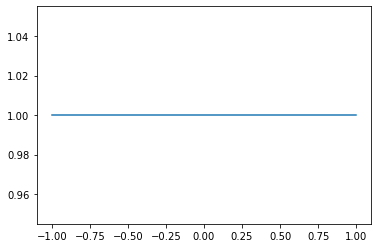

In [8]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = ddpg.actor_model(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

tf.Tensor(
[[0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999

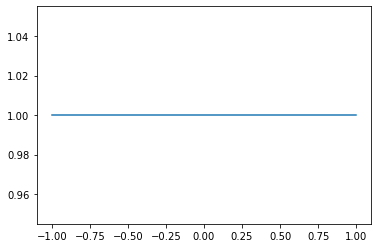

In [9]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = ddpg.actor_model(vel_pos)
print(actions_pred)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [10]:
test_policy(env, ddpg.actor_model, observation_max, observation_min, None, 5, 1, show_env=True)


KeyboardInterrupt



In [ ]:
test_policy(env, ddpg.actor_model, None, None, None, 5, 1)

In [87]:
actor_params = {
    "observation_dim": 2,
    "action_max": 1,
    "hidden_units": [16, 16]
}

critic_params = {
    "observation_dim": 2,
    "action_dim": 1,
    "state_hidden_units": [16],
    "action_hidden_units": [16],
    "out_hidden_units": [20]
}




observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])
observation_noise_stddev = [0, 0]

agent_time_ratio = 6

num_agents = 2

NORMAL_RUNS = 1
TRAN_RUNS = 0
HABIT_RUNS = 0
FLIP_DYNAMICS_RUNS = 0
EPISODES_BETWEEN_HABIT_TESTS = 1

env = gym.make('MountainCarContinuous-v0')

experiment_model_free_DDPG("../experiment_results/experiment_ddpg_mf_test", env, observation_min, observation_max, observation_noise_stddev, num_agents, NORMAL_RUNS, FLIP_DYNAMICS_RUNS, EPISODES_BETWEEN_HABIT_TESTS, actor_params, critic_params, ddpg_buffer_size=100000, ddpg_agent_time_ratio=6)

Episode 1
[-0.5882275  0.       ]


2022-10-15 19:55:08.165615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


No Success
Episode 1
[-0.43519258  0.        ]


2022-10-15 19:55:26.698391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


No Success
EXPERIMENT FINISHED


In [ ]:
# # make the HABIT ACTION NET
actor_model = get_actor(**actor_params)
critic_model = get_critic(**critic_params)
target_actor = get_actor(**actor_params)
target_critic = get_critic(**critic_params)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())
critic_optimizer = tf.keras.optimizers.Adam(0.0001)
actor_optimizer = tf.keras.optimizers.Adam(0.00005)

ou_noise = OUActionNoise(np.zeros(1), np.ones(1)*0.2)

ddpg_agent = DDPGAgent(agent_time_ratio=6, ou_noise=ou_noise, actor=actor_model, critic=critic_model, target_actor=target_actor, target_critic=target_critic, tau=0.005, buffer_capacity=500, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [52]:
a = ddpg_agent.select_action(np.array([[0, 0]]))
tf.squeeze(a).numpy()

0.0

In [54]:
env.step(a)

(array([[-0.45696074],
        [-0.00075541]], dtype=float32),
 0.0,
 False,
 {})

In [ ]:
observation_noisy = transform_observations(np.array([0, 0]), obs_max, obs_min, observation_noise_stddev)